In [1]:
!pip install pyswarm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
  Created wheel for pyswarm: filename=pyswarm-0.6-py3-none-any.whl size=4478 sha256=d390bb90a2c4cf82dc3e62162b67d248461df4265dcb67e3bcd2ab806c49343c
  Stored in directory: /root/.cache/pip/wheels/71/67/40/62fa158f497f942277cbab8199b05cb61c571ab324e67ad0d6
Successfully built pyswarm


In [2]:
import numpy as np
    
def my_pso(func, lb, ub, ieqcons=[], f_ieqcons=None, args=(), kwargs={}, 
        swarmsize=100, omega=0.5, phip=0.5, phig=0.5, maxiter=100, 
        minstep=1e-8, minfunc=1e-8, debug=False):

    assert len(lb)==len(ub), 'Lower- and upper-bounds must be the same length'
    assert hasattr(func, '__call__'), 'Invalid function handle'
    lb = np.array(lb)
    ub = np.array(ub)
    assert np.all(ub>lb), 'All upper-bound values must be greater than lower-bound values'
   
    vhigh = np.abs(ub - lb)
    vlow = -vhigh
    
    # Check for constraint function(s) #########################################
    obj = lambda x: func(x, *args, **kwargs)
    if f_ieqcons is None:
        if not len(ieqcons):
            if debug:
                print('No constraints given.')
            cons = lambda x: np.array([0])
        else:
            if debug:
                print('Converting ieqcons to a single constraint function')
            cons = lambda x: np.array([y(x, *args, **kwargs) for y in ieqcons])
    else:
        if debug:
            print('Single constraint function given in f_ieqcons')
        cons = lambda x: np.array(f_ieqcons(x, *args, **kwargs))
        
    def is_feasible(x):
        check = np.all(cons(x)>=0)
        return check
        
    # Initialize the particle swarm ############################################
    S = swarmsize
    D = len(lb)  # the number of dimensions each particle has
    x = np.random.rand(S, D)  # particle positions
    v = np.zeros_like(x)  # particle velocities
    p = np.zeros_like(x)  # best particle positions
    fp = np.zeros(S)  # best particle function values
    g = []  # best swarm position
    fg = 1e100  # artificial best swarm position starting value
    each_best=[] 
    progress=[]
    mean=0
    mean_list=[]
    for i in range(S):
        # Initialize the particle's position
        x[i, :] = lb + x[i, :]*(ub - lb)
   
        # Initialize the particle's best known position
        p[i, :] = x[i, :]
       
        # Calculate the objective's value at the current particle's
        fp[i] = obj(p[i, :])
       
        # At the start, there may not be any feasible starting point, so just
        # give it a temporary "best" point since it's likely to change
        if i==0:
            g = p[0, :].copy()

        # If the current particle's position is better than the swarm's,
        # update the best swarm position
        if fp[i]<fg and is_feasible(p[i, :]):
            print("best on this iteration found ",fg,' ',fp[i])
            fg = fp[i]
            g = p[i, :].copy()
       
        # Initialize the particle's velocity
        v[i, :] = vlow + np.random.rand(D)*(vhigh - vlow)
       
    # Iterate until termination criterion met ##################################
    it = 1
    while it<=maxiter:
        rp = np.random.uniform(size=(S, D))
        rg = np.random.uniform(size=(S, D))
        for i in range(S):
            # Update the particle's velocity
            v[i, :] = omega*v[i, :] + phip*rp[i, :]*(p[i, :] - x[i, :]) + \
                      phig*rg[i, :]*(g - x[i, :])                   
            # Update the particle's position, correcting lower and upper bound 
            # violations, then update the objective function value
            x[i, :] = x[i, :] + v[i, :]
            mark1 = x[i, :]<lb
            mark2 = x[i, :]>ub
            x[i, mark1] = lb[mark1]
            x[i, mark2] = ub[mark2]
            fx = obj(x[i, :])
            print("this is fx acc   = ",fx)
            progress.append(fx)    
            print("Swarm -------------------------------------------------------->  ",i)      
            # Compare particle's best position (if constraints are satisfied)
            if fx<fp[i] and is_feasible(x[i, :]):              
                p[i, :] = x[i, :].copy()
                fp[i] = fx
                # Compare swarm's best position to current particle's position
                # (Can only get here if constraints are satisfied)
                if fx<fg:
                    if debug:
                       # print('New best for swarm at iteration {:}: {:} {:}'.format(it, x[i, :], fx))
                       a=0
                    tmp = x[i, :].copy()
                    stepsize = np.sqrt(np.sum((g-tmp)**2))
                    if np.abs(fg - fx)<=minfunc:
                        print('Stopping search: Swarm best objective change less than {:}'.format(minfunc))
                        print("mmmm   = ",tmp,' ',fx)
                        return tmp, fx
                    elif stepsize<=minstep:
                        print('Stopping search: Swarm best position change less than {:}'.format(minstep))
                        print("xxxx   = ",tmp,' ',fx)
                        return tmp, fx
                    else:
                        g = tmp.copy()
                        print("assigning   = ",fx)
                        fg = fx
                        print('assigning mean = ',np.mean(progress))
                        mean_list.append(np.mean(progress))
                        

        if debug:
            print('Best after iteration ',it,' acuraccy  = ',fg)
            each_best.append(fg)
        it += 1
        ### do changes here
        mean_list.append(np.mean(progress))
        

    print('Stopping search: maximum iterations reached --> {:}'.format(maxiter))
    
    if not is_feasible(g):
        print("However, the optimization couldn't find a feasible design. Sorry")
    print('progress = ',progress)
    return g, fg, each_best,mean_list



In [3]:
fit_1=[]
fit_2=[]
plots_1=[]
plots_2=[]

In [12]:
from sklearn.neighbors import KNeighborsClassifier
from pandas.core.common import random_state
from numpy.random.mtrand import seed
from sklearn.preprocessing import OneHotEncoder
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from pyswarm import pso
np.random.seed(1)

#data = load_breast_cancer()
#X, y = data.data, data.target


#df = pd.DataFrame(data.data, columns=data.feature_names)
#df['target'] = data.target
#print(df.head())

# Load the dataset
data = pd.read_csv('/content/drive/MyDrive/new.csv')

# Convert the target variable to binary (assuming it's a binary classification problem)


# Split the dataset into features and target
X, y = data.iloc[:, :-1], data.iloc[:, -1]
# Define the fitness function

def fitness_function(params):
    
  
      # Convert the parameters into binary values based on a threshold
      i=0
      threshold = 0.5
      params = np.array(params) > threshold
      #print('these are the params = ',params)
      if  any(params) :
        # Select the features based on the binary values of the parameters
        selected_features = X.columns[params].tolist()
        print('these are the selected features = ',selected_features)
        #categorical_feats = X.select_dtypes(include=['object', 'category']).columns.tolist()
        categorical_feats = X.select_dtypes(include=['object', 'category', 'bool','number']).columns[params].tolist()


        categorical_features = [feat for feat in selected_features if feat in categorical_feats]
        if categorical_features:
            # One-hot encode categorical features
            encoder = OneHotEncoder()
          

            X_selected = encoder.fit_transform(X[selected_features][categorical_features])
            # Convert the encoded categorical columns to a NumPy array
            X_selected = X_selected.toarray()
            #print('after hot encoding ---> ',X_selected)
        else:
            X_selected = X[selected_features].values
        
        #print('these are the selected F_valus = ',X_selected)
        # Split the dataset into training and testing sets
        X_train, X_test, y_train, y_test = train_test_split(X_selected, y, test_size=0.2, random_state=1)
        # Initialize the classifier with the default parameters
        ###clf = RandomForestClassifier(random_state=42)
        # Fit the classifier to the training data
        ###clf.fit(X_train, y_train)
        # Predict the labels of the test data
        ###y_pred = clf.predict(X_test)
        knn = KNeighborsClassifier(n_neighbors=3)
        
        # Fit the classifier to the training data
        knn.fit(X_train, y_train)
        
        # Predict the labels of the test data
        y_pred = knn.predict(X_test)
        # Calculate the classification accuracy
        accuracy = accuracy_score(y_test, y_pred)
        # Return the negative accuracy (since PSO minimizes the fitness function)
        #print("accuracy ------> ",accuracy)
        fit_1.append(accuracy)
        #print("iter ----> ",i+1)
        return -accuracy
      else :
        return 100
n_features = X.shape[1]
lb = [0] * n_features
ub = [1] * n_features
# Use PSO to optimize the feature selection
swarmsize=2

best_params, best_fitness, to_plot, mean = my_pso(fitness_function, lb, ub, swarmsize=swarmsize, maxiter=5,phip=0.5, phig=0.5,debug=True)
plots_1=to_plot
# Convert the binary values of the best parameters to indices of selected features
threshold = 0.5
selected_features = X.columns[np.array(best_params) > threshold].tolist()

# Print the selected features and the corresponding classification accuracy
print("number of actual features are = ", len(X.columns))
print("number of selected features are = ", len(selected_features))
print("Selected features:", selected_features)
print("Best accuracy:", -best_fitness)
print('mean list = ',mean)

No constraints given.
these are the selected features =  ['sex', 'oldpeak', 'ca']
best on this iteration found  1e+100   -0.7573529411764706
these are the selected features =  ['age', 'cp', 'chol', 'thalch', 'exang', 'slope', 'ca', 'thal']
best on this iteration found  -0.7573529411764706   -0.7720588235294118
these are the selected features =  ['trestbps', 'restecg', 'thalch', 'exang', 'slope', 'ca']
this is fx acc   =  -0.7647058823529411
Swarm -------------------------------------------------------->   0
these are the selected features =  ['age', 'sex', 'cp', 'chol', 'thalch', 'exang', 'thal']
this is fx acc   =  -0.8161764705882353
Swarm -------------------------------------------------------->   1
assigning   =  -0.8161764705882353
assigning mean =  -0.7904411764705882
Best after iteration  1  acuraccy  =  -0.8161764705882353
these are the selected features =  ['trestbps', 'restecg', 'thalch', 'exang', 'slope', 'ca']
this is fx acc   =  -0.7647058823529411
Swarm ------------------

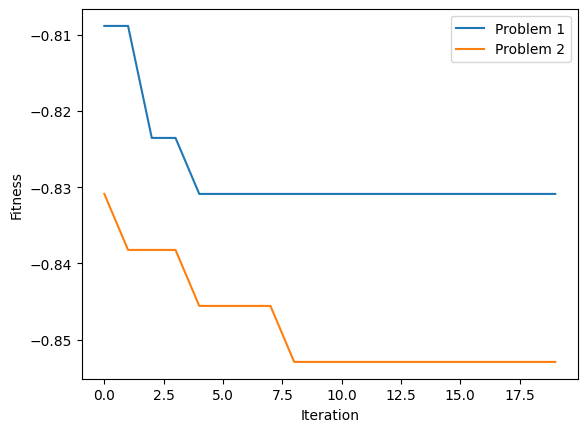

In [ ]:
import matplotlib.pyplot as plt
plt.plot(plots_1, label='Problem 1')
plt.plot(plots_2, label='Problem 2')
plt.legend()
plt.xlabel('Iteration')
plt.ylabel('Fitness')
plt.show()

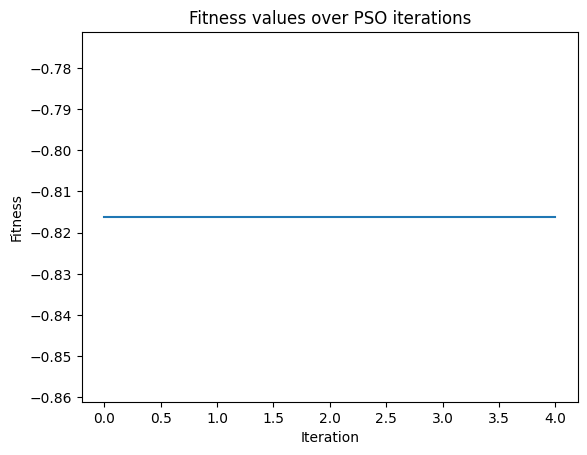

In [ ]:


plt.plot(to_plot)
plt.title("Fitness values over PSO iterations")
plt.xlabel("Iteration")
plt.ylabel("Fitness")
plt.show()

In [ ]:
for i in range(swarmsize):
    plt.plot(particle_history[:, i, 0], particle_history[:, i, 1], label="Particle " + str(i))
plt.title("Particle Trajectory over PSO Iterations")
plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.show()

TypeError: ignored

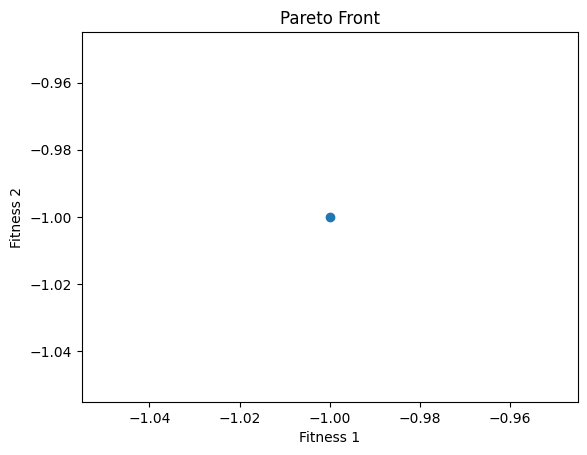

In [ ]:
import matplotlib.pyplot as plt



# Plot Pareto front
plt.scatter(best_fitness, best_fitness)
plt.title("Pareto Front")
plt.xlabel("Fitness 1")
plt.ylabel("Fitness 2")
plt.show()

In [ ]:
import numpy as np

def pso(fitness_function, lb, ub, swarmsize=10, maxiter=100, c1=2.0, c2=2.0, w=0.7):
    """
    Runs the Particle Swarm Optimization algorithm to optimize a fitness function.

    Parameters:
    fitness_function (function): The fitness function to be optimized.
    lb (numpy.ndarray): The lower bounds of the search space.
    ub (numpy.ndarray): The upper bounds of the search space.
    swarmsize (int): The number of particles in the swarm.
    maxiter (int): The maximum number of iterations.
    c1 (float): The cognitive parameter.
    c2 (float): The social parameter.
    w (float): The inertia weight.

    Returns:
    best_params (numpy.ndarray): The best parameters found by the algorithm.
    best_fitness (float): The best fitness value found by the algorithm.
    particles_history (numpy.ndarray): The position history of each particle in the swarm.
    """

    # Initialize particle positions and velocities
    dimensions = len(lb)
    particles = np.random.uniform(low=lb, high=ub, size=(swarmsize, dimensions))
    velocities = np.zeros((swarmsize, dimensions))

    # Initialize particle history
    particles_history = np.zeros((maxiter+1, swarmsize, dimensions))
    particles_history[0] = particles.copy()

    # Initialize global best position and fitness
    global_best_params = np.zeros(dimensions)
    global_best_fitness = float('inf')

    # Evaluate fitness of initial particle positions
    fitness = np.array([fitness_function(p) for p in particles])
    personal_best_params = particles.copy()
    personal_best_fitness = fitness.copy()

    # Find global best position and fitness
    idx = np.argmin(fitness)
    if fitness[idx] < global_best_fitness:
        global_best_params = particles[idx].copy()
        global_best_fitness = fitness[idx]

    # Run PSO algorithm
    for i in range(maxiter):
        # Update particle velocities
        velocities = w * velocities + \
            c1 * np.random.rand(swarmsize, dimensions) * (personal_best_params - particles) + \
            c2 * np.random.rand(swarmsize, dimensions) * (global_best_params - particles)

        # Update particle positions
        particles += velocities

        # Apply bounds to particle positions
        particles = np.clip(particles, lb, ub)

        # Evaluate fitness of new particle positions
        fitness = np.array([fitness_function(p) for p in particles])

        # Update personal best positions and fitness
        idx = fitness < personal_best_fitness
        personal_best_params[idx] = particles[idx].copy()
        personal_best_fitness[idx] = fitness[idx].copy()

        # Update global best position and fitness
        idx = np.argmin(fitness)
        if fitness[idx] < global_best_fitness:
            global_best_params = particles[idx].copy()
            global_best_fitness = fitness[idx]

        # Store particle position history
        particles_history[i+1] = particles.copy()

    return global_best_params, global_best_fitness, particles_history

In [ ]:
from pandas.core.common import random_state
from numpy.random.mtrand import seed
from sklearn.preprocessing import OneHotEncoder
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from pyswarm import pso
import pyswarms as ps
np.random.seed(5)

# Load the dataset
data = pd.read_csv('/content/drive/MyDrive/HeartDiseaseTrain-Test.csv')

# Convert the target variable to binary (assuming it's a binary classification problem)


# Split the dataset into features and target
X, y = data.iloc[:, :-1], data.iloc[:, -1]
# Define the fitness function
fit=[]
def fitness_function(params):
    
  
      # Convert the parameters into binary values based on a threshold
      threshold = 0.5
      params = np.array(params) > threshold
      print('these are the params = ',params)
      if  any(params) :
        # Select the features based on the binary values of the parameters
        selected_features = X.columns[params].tolist()
        print('these are the selected features = ',selected_features)
        #categorical_feats = X.select_dtypes(include=['object', 'category']).columns.tolist()
        categorical_feats = X.select_dtypes(include=['object', 'category', 'bool','number']).columns[params].tolist()


        categorical_features = [feat for feat in selected_features if feat in categorical_feats]
        if categorical_features:
            # One-hot encode categorical features
            encoder = OneHotEncoder()
          

            X_selected = encoder.fit_transform(X[selected_features][categorical_features])
            # Convert the encoded categorical columns to a NumPy array
            X_selected = X_selected.toarray()
            #print('after hot encoding ---> ',X_selected)
        else:
            X_selected = X[selected_features].values
        
        #print('these are the selected F_valus = ',X_selected)
        # Split the dataset into training and testing sets
        X_train, X_test, y_train, y_test = train_test_split(X_selected, y, test_size=0.2, random_state=42)
        # Initialize the classifier with the default parameters
        clf = RandomForestClassifier(random_state=42)
        # Fit the classifier to the training data
        clf.fit(X_train, y_train)
        # Predict the labels of the test data
        y_pred = clf.predict(X_test)
        # Calculate the classification accuracy
        accuracy = accuracy_score(y_test, y_pred)
        # Return the negative accuracy (since PSO minimizes the fitness function)
        print("accuracy ------> ",accuracy)
        fit.append(-accuracy)
        return -accuracy
      else :
        return 100
particle_history = []

# Define the callback function to update the particle history
def callback(xk, **kwargs):
    particle_history.append(xk)
# Define the bounds for the parameters (binary values for each feature)
n_features = X.shape[1]
lb = [0] * n_features
ub = [1] * n_features
# Use PSO to optimize the feature selection
swarmsize=10
best_params, best_fitness = ps.single.GlobalBestPSO(fitness_function, lb, ub, swarmsize=swarmsize, maxiter=)

# print the results
print("Best parameters:", best_params)
print("Best fitness:", best_fitness)

# plot the cost history
import matplotlib.pyplot as plt

plt.plot(best_fitness)
plt.xlabel("Iterations")
plt.ylabel("Cost")
plt.show()

NameError: ignored

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
import pyswarms as ps

# Load the dataset
data = pd.read_csv('/content/drive/MyDrive/HeartDiseaseTrain-Test.csv')

# Convert the target variable to binary (assuming it's a binary classification problem)


# Split the dataset into features and target
X, y = data.iloc[:, :-1], data.iloc[:, -1]

# Define the fitness function
def fitness_function(params, X, y):
    # Convert the parameters into binary values based on a threshold
    features = params.astype(bool)
    print("these are the features -----> ", features)
    # Select the features based on the binary values of the parameters
    selected_columns = np.where(features)[0]
    X_selected = X.iloc[:, selected_columns]
    
    # Split the dataset into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X_selected, y, test_size=0.2, random_state=42)
    
    # Initialize the classifier with default parameters
    clf = RandomForestClassifier(random_state=42)
    
    # Fit the classifier to the training data
    clf.fit(X_train, y_train)
    
    # Predict the labels of the test data
    y_pred = clf.predict(X_test)
    
    # Calculate the classification accuracy
    accuracy = accuracy_score(y_test, y_pred)
    
    # Return the negative accuracy (since PSO minimizes the fitness function)
    return -accuracy

# Define the bounds for the parameters (binary values for each feature)
n_features = X.shape[1]
lb = [0] * n_features
ub = [1] * n_features
bounds = (lb, ub)
print("features  ----> ",n_features)
print("bounds ----> ",bounds)
# Use PSO to optimize the feature selection
swarmsize = 30
options = {'c1': 0.5, 'c2': 0.3, 'w':0.9}

optimizer = ps.single.GlobalBestPSO(n_particles=swarmsize, dimensions=n_features, options=options,bounds=bounds)
cost, pos = optimizer.optimize(fitness_function, iters=10, X=X, y=y)

# Convert the binary values of the best parameters to indices of selected features
threshold = 0.5
selected_features = X.columns[np.array(pos) > threshold].tolist()

# Print the selected features and the corresponding classification accuracy
print("number of actual features are = ", len(X.columns))
print("number of selected features are = ", len(selected_features))
print("Selected features:", selected_features)
print("Best accuracy:", -cost)

2023-04-17 13:25:17,743 - pyswarms.single.global_best - INFO - Optimize for 10 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}


features  ---->  13
bounds ---->  ([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])


pyswarms.single.global_best:   0%|          |0/10

these are the features ----->  [[ True  True  True  True  True  True  True  True  True  True  True  True
   True]
 [ True  True  True  True  True  True  True  True  True  True  True  True
   True]
 [ True  True  True  True  True  True  True  True  True  True  True  True
   True]
 [ True  True  True  True  True  True  True  True  True  True  True  True
   True]
 [ True  True  True  True  True  True  True  True  True  True  True  True
   True]
 [ True  True  True  True  True  True  True  True  True  True  True  True
   True]
 [ True  True  True  True  True  True  True  True  True  True  True  True
   True]
 [ True  True  True  True  True  True  True  True  True  True  True  True
   True]
 [ True  True  True  True  True  True  True  True  True  True  True  True
   True]
 [ True  True  True  True  True  True  True  True  True  True  True  True
   True]
 [ True  True  True  True  True  True  True  True  True  True  True  True
   True]
 [ True  True  True  True  True  True  True  True  True 

IndexError: ignored

In [ ]:
import pandas as pd


x=pd.read_excel('/content/heart_data.xlsx')

In [ ]:
import pandas as pd
import numpy as np


# Loop through columns and fill NaN values with mean
for col in x.columns:
    mean = x[col].mean()
    x[col].fillna(mean, inplace=True)

In [ ]:
print(x.isna().any())

age         False
sex         False
cp          False
trestbps    False
chol        False
fbs         False
restecg     False
thalch      False
exang       False
oldpeak     False
slope       False
ca          False
thal        False
num         False
dtype: bool


In [ ]:
x.to_csv('disease.csv', index=False)